## Imports

In [19]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix
import pathlib
import splitfolders

def plot_confusion_matrix(y_true, y_pred, classes,
                          cmap=plt.cm.YlGn):
    title="Confusion Matrix"

    cm = confusion_matrix(y_true, y_pred)
    classes = classes

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    plt.setp(ax.get_xticklabels(), rotation=28, ha="right",rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## Dataset Load

In [20]:
dataset_dir=pathlib.Path('output/')

batch_size=32
img_height=160
img_width=200

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_dir=pathlib.Path('output/train/')
val_dir=pathlib.Path('output/val/')

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

Found 6259 images belonging to 8 classes.
Found 1338 images belonging to 8 classes.
Image input (160, 200, 3)
Classes: ['Carpet_Cleaners', 'Figs', 'Forks', 'Oatmeal_box', 'Puffed_Snacks', 'Sports_Drinking_Water', 'decorative_tray', 'pasta_bowl']


## Load VGG16 pre-trained

In [21]:
def load_vgg16_features(input_shape, init_weights=None):
    
    #input tensor
    input0 = Input(shape=input_shape)

    # load VGG16 model without the final dense layers 
    vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input0)
    
    feature_extractor = keras.models.Model(inputs=input0, outputs=vgg16_model.output, name="vgg16_features")

    optimizer = 'adam' 

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return feature_extractor

vgg16feat_model = load_vgg16_features(input_shape)
vgg16feat_model.summary()

Model: "vgg16_features"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 50, 128)    

## Transfer-Net

In [22]:
def transferNet(input_shape, num_classes, output_layer_name, trainable_layers):
    
    # load the pre-trained model with the weight computed with imagenet
    feature_extractor = load_vgg16_features(input_shape, init_weights='imagenet')

    # original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense1 = Dropout(0.4)(flatten_norm)
    dense1 = Dense(128, activation='relu')(dense1)
    dense1 = BatchNormalization()(dense1)
    
    # add a Dense layer
    dense2 = Dropout(0.4)(dense1)
    dense2 = Dense(92, activation='relu')(dense2)
    dense2 = BatchNormalization()(dense2)

    # add the final output layer
    dense3 = BatchNormalization()(dense2)
    dense3 = Dense(num_classes, activation='softmax')(dense3)
    
    model = keras.models.Model(inputs=input_t, outputs=dense3, name="transferNet")
    
    optimizer = 'adam' 
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model



# layer from which you can get the features  
name_output_extractor = "block5_pool"
#we train only the last layer
trainable_layers = ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(input_shape, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

Model: "transferNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 160, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 50, 128)       

## Training the new model

In [8]:
stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = test_generator.n//test_generator.batch_size+1

epochs = 25
try:
    transfer_history = transfer_model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


Epoch 1/25
195/195 [==============================] - 1284s 7s/step - loss: 1.1532 - accuracy: 0.6082 - val_loss: 0.8285 - val_accuracy: 0.7152
Epoch 2/25
195/195 [==============================] - 1265s 6s/step - loss: 0.8334 - accuracy: 0.7169 - val_loss: 0.7796 - val_accuracy: 0.7339
Epoch 3/25
195/195 [==============================] - 1270s 7s/step - loss: 0.7283 - accuracy: 0.7532 - val_loss: 0.6452 - val_accuracy: 0.7892
Epoch 4/25
195/195 [==============================] - 1269s 7s/step - loss: 0.6450 - accuracy: 0.7784 - val_loss: 0.6370 - val_accuracy: 0.7975
Epoch 5/25
195/195 [==============================] - 1270s 7s/step - loss: 0.5898 - accuracy: 0.7997 - val_loss: 0.6538 - val_accuracy: 0.7900
Epoch 6/25
195/195 [==============================] - 1269s 7s/step - loss: 0.5651 - accuracy: 0.8110 - val_loss: 0.6119 - val_accuracy: 0.7997
Epoch 7/25
195/195 [==============================] - 1262s 6s/step - loss: 0.5285 - accuracy: 0.8187 - val_loss: 0.6220 - val_accuracy:

## Save the model

In [9]:
import os
import pickle

models_dir='./Models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)
    
def savehistory(history,problem):
    filename = os.path.join(models_dir, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHystory saved on file %s\n" %filename)

# Save the model
savemodel(transfer_model,'HW2_2_transfer_17epoc')
savehistory(transfer_history,'Hw2_2_transfer_17epoc')



Model saved successfully on file ./Models/HW2_2_transfer_17epoc.h5


Hystory saved on file ./Models/Hw2_2_transfer_17epoc.hist



## Plots

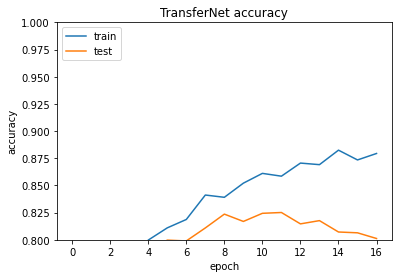

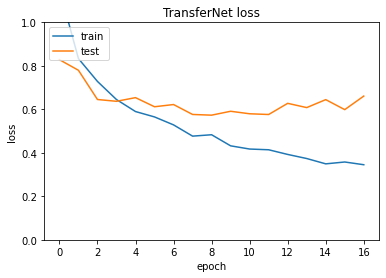

In [10]:
def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0.8,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0.0,1.0)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
name="TransferNet"
plot_history(transfer_history, name)

## Evaluate

In [12]:
test_dir=pathlib.Path('output/test')

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = transfer_model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

Found 1352 images belonging to 8 classes.
43/43 [==============================] - 247s 6s/step - loss: 0.6583 - accuracy: 0.8143
Test loss: 0.658250
Test accuracy: 0.814349


## Classification Report and Confusion Matrix

Found 1352 images belonging to 8 classes.
43/43 [==============================] - 218s 5s/step
                       precision    recall  f1-score   support

      Carpet_Cleaners      0.825     0.830     0.828       159
                 Figs      0.770     0.906     0.832       159
                Forks      0.916     0.766     0.834       184
          Oatmeal_box      0.642     0.720     0.679       157
        Puffed_Snacks      0.872     0.711     0.783       173
Sports_Drinking_Water      0.895     0.890     0.892       172
      decorative_tray      0.726     0.885     0.798       174
           pasta_bowl      0.934     0.810     0.868       174

             accuracy                          0.814      1352
            macro avg      0.822     0.815     0.814      1352
         weighted avg      0.826     0.814     0.816      1352

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
pasta_bowl       ->  de

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

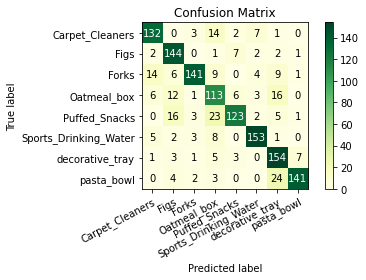

In [13]:
test_dir=pathlib.Path('output/test')

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

preds = transfer_model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

plot_confusion_matrix(Ytest,Ypred, classes=classnames)